# Poisson equation in a multi-patch domain

In [1]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=100000)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology
from pyiga import assemble_cy

In [2]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 10
kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(np.pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-np.pi/2).translate((-2, 1))
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

setting up constraints took 0.004714012145996094 seconds.
Basis setup took 0.002139568328857422 seconds


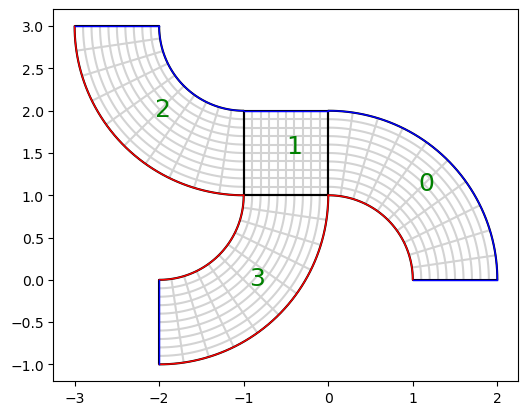

In [4]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: np.exp(-5 * ((x-0.3)**2 + (y-1)**2))
gD = lambda x, y: 1e-1 * np.sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
gN = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Neumann/Robin':{(0,2),(2,3),(3,2),(3,3)},
                   'Dirichlet':{(0,0),(0,3),(1,1),(2,0),(2,2),(3,0)}})

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
fig, ax = plt.subplots(1,1, figsize=(6,6))
M.plotmesh(patch_idx = True, knots=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'}, axis=ax)
ax.axis('scaled');
# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("inner(grad(u), grad(v)) * dx", arity = 2)
Fh = MP.assemble_volume("f * v * dx", arity=1, physical=True, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann/Robin')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Neumann/Robin')

In [5]:
M.patches[0][0][1]

AttributeError: 'BSplineFunc' object has no attribute 'control_points'

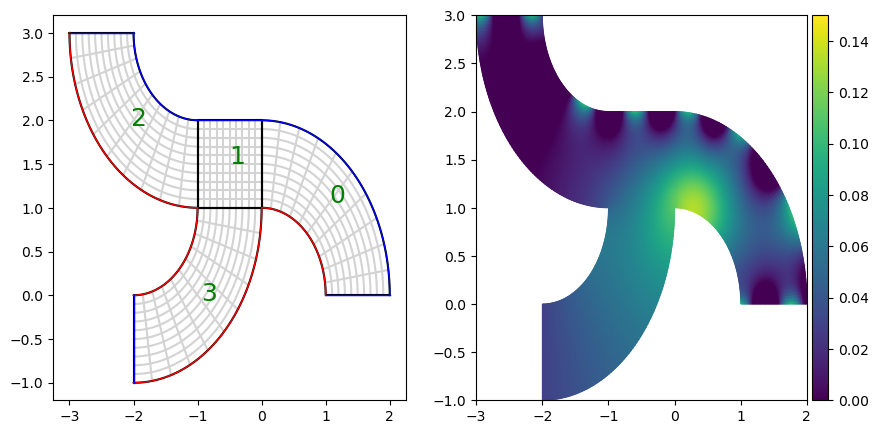

In [6]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

# restrict solution to each individual patch (kvs on every patch) and visualize solution together with the mesh
fig, ax = plt.subplots(1,2,figsize=(10,5))
M.plotmesh(patch_idx = True, knots=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'}, axis=ax[0])
MP.plot(u, range = (0, 1.5e-1),cbar=True, cmap='viridis', axis=ax[1])
ax[0].axis('scaled'); ax[1].axis('scaled');

In [5]:
MP.plot(u, range = (0, 1.5e-1), cmap='viridis')

NameError: name 'MP' is not defined

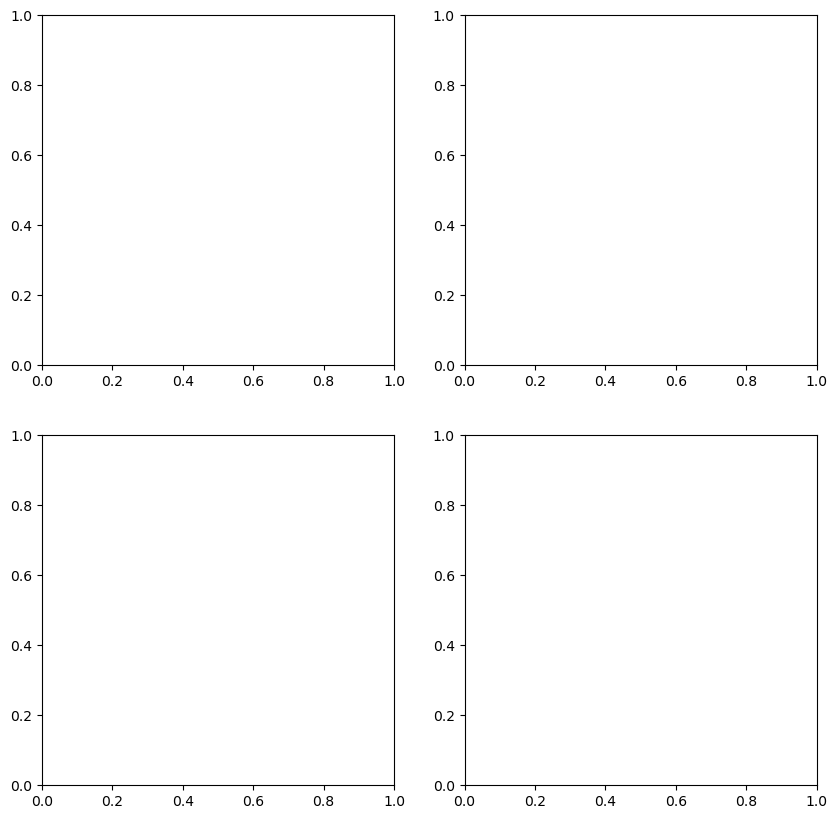

In [12]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
vis.plot_geo()

# Computerchip

In [8]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 10
kvs = 8 * [2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [9]:
# define geometry
geos = [
    geometry.Quad(np.array([[0,0.5,0.35, 0.5],[0,0,0.3,0.15]])),
    geometry.Quad(np.array([[0, 0.35, 0, 0.17],[0, 0.3, 0.6, 0.6]])),
    geometry.Quad(np.array([[0.35, 0.5, 0.17, 0.5],[0.3, 0.45, 0.6, 0.6]])),
    geometry.Quad(np.array([[0.17, 0.5, 0.17, 0.5],[0.6, 0.6, 0.8, 0.8]])),
    geometry.Quad(np.array([[0.5,1,0.5, 0.65],[0,0,0.15,0.3]])),
    geometry.Quad(np.array([[0.65, 1, 0.83,1],[0.3,0,0.6,0.6]])),
    geometry.Quad(np.array([[0.65, 0.83, 0.5, 0.5],[0.3, 0.6, 0.45, 0.6]])),
    geometry.Quad(np.array([[0.5, 0.83, 0.5, 0.83],[0.6, 0.6, 0.8, 0.8]])),
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

In [11]:
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Dirichlet' : {(0,0),(4,0)},
                   'Robin':{(1,1),(1,2),(3,1),(3,2),(5,1),(5,3),(7,1),(7,3)},
                   'Dirichlet':{(0,1),(2,0),(4,1),(6,2)}})

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
#M.draw(patch_idx = True, knots=True, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)

In [13]:
M.outer_boundaries

{0: {(0, 0), (4, 0)},
 'Dirichlet': {(0, 1), (2, 0), (4, 1), (6, 2)},
 'Robin': {(1, 1), (1, 2), (3, 1), (3, 2), (5, 1), (5, 3), (7, 1), (7, 3)}}

In [65]:
A = scipy.sparse.csc_matrix(np.array([[1,2,0],[4,5,6]]))

In [67]:
A.getnnz(0)

array([2, 2, 1], dtype=int32)

# Using non-matching multi-patch domains for adaptive refinement